In [124]:
import pandas as pd
import tqdm
import math
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
# !pip install catboost
from catboost import CatBoostClassifier
import numpy as np
import typing
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error


In [2]:
df = pd.read_excel("./result.xlsx", engine="openpyxl")

In [3]:
df.head()

,Unnamed: 0,Название,ИНН,Адрес,"Признаки, установленные Банком России",Деятельность прекращена
0,0,"ИНВЕСТИЦИОННЫЙ ПОТРЕБИТЕЛЬСКИЙ КООПЕРАТИВ ""АБС...",7728496210,"105082, г. Москва, Спартаковская площадь, д.14...","Признаки ""финансовой пирамиды""",0
1,1,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АВРО...",7751027337,"109004, г. Москва, ул. Николоямская, д. 40/22,...","Признаки ""финансовой пирамиды""",0
2,2,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ДОН ...",6155090008,"346500, Ростовская область, г. Шахты, пер. Кра...",Признаки нелегального кредитора,0
3,3,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ЛИЗИ...",6165228311,"344038, Ростовская область, г. Ростов-на-Дону,...",Признаки нелегального кредитора,0
4,4,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ПРЕМ...",7743699335,"125565, г. Москва, Ленинградское шоссе, д. 84,...","Признаки ""финансовой пирамиды""",0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156 entries, 0 to 1155
Data columns (total 6 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Unnamed: 0                             1156 non-null   int64 
 1   Название                               1156 non-null   object
 2   ИНН                                    1156 non-null   int64 
 3   Адрес                                  1156 non-null   object
 4   Признаки, установленные Банком России  1156 non-null   object
 5   Деятельность прекращена                1156 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 54.3+ KB


In [5]:
df = df[df['ИНН'].notna()]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1156 entries, 0 to 1155
Data columns (total 6 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Unnamed: 0                             1156 non-null   int64 
 1   Название                               1156 non-null   object
 2   ИНН                                    1156 non-null   int64 
 3   Адрес                                  1156 non-null   object
 4   Признаки, установленные Банком России  1156 non-null   object
 5   Деятельность прекращена                1156 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 63.2+ KB


In [7]:
## Парсинг
import requests
from bs4 import BeautifulSoup
final_ds = df.copy
ddf = df.copy()

In [8]:
session = requests.Session()
response = session.get(url_for_bfo_id, headers={'User-Agent': 'Mozilla/5.0'})
response_dict = json.loads(response.text)
not(not response_dict)

NameError: name 'url_for_bfo_id' is not defined

In [11]:
from multiprocessing import Pool
import json

In [49]:
form_ds = []
for row in tqdm.tqdm((ddf.iterrows())):
    inn = (int(row[1]['ИНН']))
    url = 'https://bo.nalog.ru/nbo/organizations/search?query=' + str(int(inn)) + '&page=0/'
    session = requests.Session()
    response = session.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    response_dict = json.loads(response.text)
    if not(not(response_dict['content'])):
        id_org = response_dict['content'][0]['id']
        region = response_dict['content'][0]['region']
        city = response_dict['content'][0]['city']
#         print(region)
        url_for_bfo_id = 'https://bo.nalog.ru/nbo/organizations/' + str(int(id_org)) + '/bfo'
        response = session.get(url_for_bfo_id, headers={'User-Agent': 'Mozilla/5.0'})
        response_dict = json.loads(response.text)
        if not (not response_dict):
            if response_dict[0]['period'] == '2020':
                id_otchetnost_2020 = response_dict[0]['id']
#                 print(id_otchetnost_2020)
                url_id_otchetnost = 'https://bo.nalog.ru/nbo/bfo/' + str(id_otchetnost_2020) + '/details'
                response = session.get(url_id_otchetnost, headers={'User-Agent': 'Mozilla/5.0'})
                if not (not response.text):
                    response_dict = json.loads(response.text)
#                 print(response_dict[0]["financialResult"]["expl2100"])
                    try:
                        viruchka = response_dict[0]["financialResult"]['current2110']
                    except:
                        viruchka = float('nan')
                    try:
                        ybitok = response_dict[0]["financialResult"]["current2100"]
                    except:
                        ybitok = float('nan')
                    try:
                        capital = response_dict[0]["balance"]["current1300"]
                    except:
                        capital = float('nan')
                    try:
                        vne_aktiv = response_dict[0]["balance"]["current1100"]
                    except:
                        vne_akriv = float('nan')
                    try:
                        obor_activ = response_dict[0]["balance"]["current1200"]
                    except:
                        obor_activ = float('nan')
                    try:
                        clear_pibil = response_dict[0]["financialResult"]['current2400']
                    except:
                        clear_pibil = float('nan')
                    try:
                        sovok_fin_otch = response_dict[0]["financialResult"]['current2500']
                    except:
                        sovok_fin_otch = float('nan')
                    try:
                        den_sr_and_equal = response_dict[0]["balance"]["current1250"]
                    except:
                        den_sr_and_equal = float('nan')
                    form_ds.append({'Название':row[1]['Название'] , 'ИНН':int(row[1]['ИНН']),
                                    'Признаки, установленные Банком России':row[1]['Признаки, установленные Банком России'],
                                    'Регион':region,
                                    'Выручка':viruchka, 'Убыток':ybitok,
                                    'Капитал':capital, 'Вн_о_активы':vne_aktiv,
                                    'Чистая прибыль': clear_pibil,
                                    'Совокупный фин.отчет': sovok_fin_otch,
                                    'Денежные средства и эквиваленты': den_sr_and_equal,
                                    'Обор_активы':obor_activ})


1156it [09:09,  2.11it/s]


In [50]:
form_ds = pd.DataFrame(form_ds)
form_ds

,Название,ИНН,"Признаки, установленные Банком России",Регион,Выручка,Убыток,Капитал,Вн_о_активы,Чистая прибыль,Совокупный фин.отчет,Денежные средства и эквиваленты,Обор_активы
0,"ИНВЕСТИЦИОННЫЙ ПОТРЕБИТЕЛЬСКИЙ КООПЕРАТИВ ""АБС...",7728496210,"Признаки ""финансовой пирамиды""",МОСКВА,NaN,0.0,10.0,NaN,NaN,NaN,10.0,10.0
1,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АВРО...",7751027337,"Признаки ""финансовой пирамиды""",МОСКВА,NaN,NaN,300001.0,NaN,-37.0,NaN,3001.0,NaN
2,ПОТРЕБИТЕЛЬСКОЕ ОБЩЕСТВО МЕЖДУНАРОДНЫЙ КООПЕРА...,7702844336,"Признаки ""финансовой пирамиды""",МОСКВА,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АПРЕ...",7702460241,Признаки нелегального кредитора,МОСКВА,4052.0,4052.0,1856.0,80.0,-109.0,-109.0,655.0,3303.0
4,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ЛОМБ...",5036063116,Признаки нелегального кредитора,МОСКОВСКАЯ,2514.0,2514.0,1877.0,NaN,7.0,7.0,141.0,2253.0
...,...,...,...,...,...,...,...,...,...,...,...,...
475,Анжерский машиностроительный завод,4201000625,нет,КЕМЕРОВСКАЯ ОБЛАСТЬ - КУЗБАСС,1505737.0,598046.0,940644.0,212743.0,469786.0,469067.0,353921.0,1181090.0
476,Топкинский цементный завод,4229004316,нет,КЕМЕРОВСКАЯ ОБЛАСТЬ - КУЗБАСС,9435773.0,5215554.0,13479427.0,13896849.0,748954.0,748954.0,53644.0,4922646.0
477,Новокузнецкий алюминиевый завод,4221000535,нет,КЕМЕРОВСКАЯ ОБЛАСТЬ - КУЗБАСС,16947188.0,2197186.0,1731887.0,2914683.0,160685.0,160685.0,2701.0,5268325.0
478,Новокузнецкий завод резервуарных металлоконстр...,4221002780,нет,КЕМЕРОВСКАЯ ОБЛАСТЬ - КУЗБАСС,1350380.0,124827.0,305945.0,383272.0,14423.0,14423.0,4742.0,966966.0


In [51]:
form_ds.isnull().sum()

Название                                   0
ИНН                                        0
Признаки, установленные Банком России      0
Регион                                     0
Выручка                                  193
Убыток                                   325
Капитал                                   39
Вн_о_активы                              365
Чистая прибыль                           131
Совокупный фин.отчет                     290
Денежные средства и эквиваленты           78
Обор_активы                              221
dtype: int64

In [71]:
form_ds.to_csv('dataset.csv',index=False)

In [72]:
scaler_df = form_ds.copy()
# scaler_df[['Выручка','Убыток', 'Капитал', 'Вн_о_активы','Чистая прибыль','Совокупный фин.отчет','Денежные средства и эквиваленты','Обор_активы']] = scaler_df[['Выручка','Убыток', 'Капитал', 'Вн_о_активы','Чистая прибыль','Совокупный фин.отчет','Денежные средства и эквиваленты','Обор_активы']].fillna(scaler_df[['Выручка','Убыток', 'Капитал', 'Вн_о_активы','Чистая прибыль','Совокупный фин.отчет','Денежные средства и эквиваленты','Обор_активы']].mean())
# scaler_df
imputer = KNNImputer(n_neighbors=2)
scaler_df[['Выручка','Убыток', 'Капитал', 'Вн_о_активы','Чистая прибыль','Совокупный фин.отчет','Денежные средства и эквиваленты','Обор_активы']] = imputer.fit_transform(scaler_df[['Выручка','Убыток', 'Капитал', 'Вн_о_активы','Чистая прибыль','Совокупный фин.отчет','Денежные средства и эквиваленты','Обор_активы']])
scaler_df

,Название,ИНН,"Признаки, установленные Банком России",Регион,Выручка,Убыток,Капитал,Вн_о_активы,Чистая прибыль,Совокупный фин.отчет,Денежные средства и эквиваленты,Обор_активы
0,"ИНВЕСТИЦИОННЫЙ ПОТРЕБИТЕЛЬСКИЙ КООПЕРАТИВ ""АБС...",7728496210,"Признаки ""финансовой пирамиды""",МОСКВА,0.0,0.0,10.0,0.0,0.0,0.0,10.0,10.0
1,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АВРО...",7751027337,"Признаки ""финансовой пирамиды""",МОСКВА,400.5,26.5,300001.0,645.0,-37.0,-68.0,3001.0,82249.0
2,ПОТРЕБИТЕЛЬСКОЕ ОБЩЕСТВО МЕЖДУНАРОДНЫЙ КООПЕРА...,7702844336,"Признаки ""финансовой пирамиды""",МОСКВА,11.5,1.0,7.0,0.0,-2.0,-2.0,0.0,2396.0
3,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АПРЕ...",7702460241,Признаки нелегального кредитора,МОСКВА,4052.0,4052.0,1856.0,80.0,-109.0,-109.0,655.0,3303.0
4,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ЛОМБ...",5036063116,Признаки нелегального кредитора,МОСКОВСКАЯ,2514.0,2514.0,1877.0,597.5,7.0,7.0,141.0,2253.0
...,...,...,...,...,...,...,...,...,...,...,...,...
475,Анжерский машиностроительный завод,4201000625,нет,КЕМЕРОВСКАЯ ОБЛАСТЬ - КУЗБАСС,1505737.0,598046.0,940644.0,212743.0,469786.0,469067.0,353921.0,1181090.0
476,Топкинский цементный завод,4229004316,нет,КЕМЕРОВСКАЯ ОБЛАСТЬ - КУЗБАСС,9435773.0,5215554.0,13479427.0,13896849.0,748954.0,748954.0,53644.0,4922646.0
477,Новокузнецкий алюминиевый завод,4221000535,нет,КЕМЕРОВСКАЯ ОБЛАСТЬ - КУЗБАСС,16947188.0,2197186.0,1731887.0,2914683.0,160685.0,160685.0,2701.0,5268325.0
478,Новокузнецкий завод резервуарных металлоконстр...,4221002780,нет,КЕМЕРОВСКАЯ ОБЛАСТЬ - КУЗБАСС,1350380.0,124827.0,305945.0,383272.0,14423.0,14423.0,4742.0,966966.0


In [73]:
scaler_df.isnull().sum()

Название                                 0
ИНН                                      0
Признаки, установленные Банком России    0
Регион                                   0
Выручка                                  0
Убыток                                   0
Капитал                                  0
Вн_о_активы                              0
Чистая прибыль                           0
Совокупный фин.отчет                     0
Денежные средства и эквиваленты          0
Обор_активы                              0
dtype: int64

In [159]:
scaler_df["Признаки, установленные Банком России"] = scaler_df["Признаки, установленные Банком России"].astype('category')
scaler_df["Признаки, установленные Банком России"] = scaler_df["Признаки, установленные Банком России"].cat.codes
scaler_df["Регион"] = scaler_df["Регион"].astype('category')
scaler_df["Регион"] = scaler_df["Регион"].cat.codes
scaler_df

,Название,ИНН,"Признаки, установленные Банком России",Регион,Выручка,Убыток,Капитал,Вн_о_активы,Чистая прибыль,Совокупный фин.отчет,Денежные средства и эквиваленты,Обор_активы
0,"ИНВЕСТИЦИОННЫЙ ПОТРЕБИТЕЛЬСКИЙ КООПЕРАТИВ ""АБС...",7728496210,1,31,0.0,0.0,10.0,0.0,0.0,0.0,10.0,10.0
1,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АВРО...",7751027337,1,31,400.5,26.5,300001.0,645.0,-37.0,-68.0,3001.0,82249.0
2,ПОТРЕБИТЕЛЬСКОЕ ОБЩЕСТВО МЕЖДУНАРОДНЫЙ КООПЕРА...,7702844336,1,31,11.5,1.0,7.0,0.0,-2.0,-2.0,0.0,2396.0
3,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АПРЕ...",7702460241,1,31,4052.0,4052.0,1856.0,80.0,-109.0,-109.0,655.0,3303.0
4,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ЛОМБ...",5036063116,1,32,2514.0,2514.0,1877.0,597.5,7.0,7.0,141.0,2253.0
...,...,...,...,...,...,...,...,...,...,...,...,...
475,Анжерский машиностроительный завод,4201000625,0,19,1505737.0,598046.0,940644.0,212743.0,469786.0,469067.0,353921.0,1181090.0
476,Топкинский цементный завод,4229004316,0,19,9435773.0,5215554.0,13479427.0,13896849.0,748954.0,748954.0,53644.0,4922646.0
477,Новокузнецкий алюминиевый завод,4221000535,0,19,16947188.0,2197186.0,1731887.0,2914683.0,160685.0,160685.0,2701.0,5268325.0
478,Новокузнецкий завод резервуарных металлоконстр...,4221002780,0,19,1350380.0,124827.0,305945.0,383272.0,14423.0,14423.0,4742.0,966966.0


In [1]:
# cleanup_nums = {"Признаки, установленные Банком России":     {'Признаки "финансовой пирамиды"': 1,
#                                                               "Признаки нелегального кредитора": 1,
#                                                              "Признаки нелегального профессионального участника рынка ценных бумаг": 1,
#                                                              'Признаки "финансовой пирамиды", признаки нелегального кредитора':1,
#                                                              'нет':0}}
# scaler_df = scaler_df.replace(cleanup_nums)
# scaler_df

In [160]:
scaler_df.to_excel('scaler_df.xlsx',index=False, engine="openpyxl")

In [79]:
res_final = pd.read_excel("./res_final.xlsx", engine="openpyxl")
res_final

,Unnamed: 0,Название,ИНН,"Признаки, установленные Банком России",Регион,Выручка,Убыток,Капитал,Вн_о_активы,Чистая прибыль,Совокупный фин.отчет,Денежные средства и эквиваленты,Обор_активы,Num_p
0,0,"ИНВЕСТИЦИОННЫЙ ПОТРЕБИТЕЛЬСКИЙ КООПЕРАТИВ ""АБС...",7728496210,1,МОСКВА,0.0,0.0,10.0,0.0,0.0,0.0,10.0,10.0,NaN
1,1,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АВРО...",7751027337,1,МОСКВА,400.5,26.5,300001.0,645.0,-37.0,-68.0,3001.0,82249.0,NaN
2,2,ПОТРЕБИТЕЛЬСКОЕ ОБЩЕСТВО МЕЖДУНАРОДНЫЙ КООПЕРА...,7702844336,1,МОСКВА,11.5,1.0,7.0,0.0,-2.0,-2.0,0.0,2396.0,NaN
3,3,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АПРЕ...",7702460241,1,МОСКВА,4052.0,4052.0,1856.0,80.0,-109.0,-109.0,655.0,3303.0,3.0
4,4,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ЛОМБ...",5036063116,1,МОСКОВСКАЯ,2514.0,2514.0,1877.0,597.5,7.0,7.0,141.0,2253.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,475,Анжерский машиностроительный завод,4201000625,0,КЕМЕРОВСКАЯ ОБЛАСТЬ - КУЗБАСС,1505737.0,598046.0,940644.0,212743.0,469786.0,469067.0,353921.0,1181090.0,424.0
476,476,Топкинский цементный завод,4229004316,0,КЕМЕРОВСКАЯ ОБЛАСТЬ - КУЗБАСС,9435773.0,5215554.0,13479427.0,13896849.0,748954.0,748954.0,53644.0,4922646.0,1146.0
477,477,Новокузнецкий алюминиевый завод,4221000535,0,КЕМЕРОВСКАЯ ОБЛАСТЬ - КУЗБАСС,16947188.0,2197186.0,1731887.0,2914683.0,160685.0,160685.0,2701.0,5268325.0,NaN
478,478,Новокузнецкий завод резервуарных металлоконстр...,4221002780,0,КЕМЕРОВСКАЯ ОБЛАСТЬ - КУЗБАСС,1350380.0,124827.0,305945.0,383272.0,14423.0,14423.0,4742.0,966966.0,1136.0


In [80]:
res_final[['Num_p']] = imputer.fit_transform(res_final[['Num_p']])
res_final

,Unnamed: 0,Название,ИНН,"Признаки, установленные Банком России",Регион,Выручка,Убыток,Капитал,Вн_о_активы,Чистая прибыль,Совокупный фин.отчет,Денежные средства и эквиваленты,Обор_активы,Num_p
0,0,"ИНВЕСТИЦИОННЫЙ ПОТРЕБИТЕЛЬСКИЙ КООПЕРАТИВ ""АБС...",7728496210,1,МОСКВА,0.0,0.0,10.0,0.0,0.0,0.0,10.0,10.0,27.740831
1,1,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АВРО...",7751027337,1,МОСКВА,400.5,26.5,300001.0,645.0,-37.0,-68.0,3001.0,82249.0,27.740831
2,2,ПОТРЕБИТЕЛЬСКОЕ ОБЩЕСТВО МЕЖДУНАРОДНЫЙ КООПЕРА...,7702844336,1,МОСКВА,11.5,1.0,7.0,0.0,-2.0,-2.0,0.0,2396.0,27.740831
3,3,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АПРЕ...",7702460241,1,МОСКВА,4052.0,4052.0,1856.0,80.0,-109.0,-109.0,655.0,3303.0,3.000000
4,4,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ЛОМБ...",5036063116,1,МОСКОВСКАЯ,2514.0,2514.0,1877.0,597.5,7.0,7.0,141.0,2253.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,475,Анжерский машиностроительный завод,4201000625,0,КЕМЕРОВСКАЯ ОБЛАСТЬ - КУЗБАСС,1505737.0,598046.0,940644.0,212743.0,469786.0,469067.0,353921.0,1181090.0,424.000000
476,476,Топкинский цементный завод,4229004316,0,КЕМЕРОВСКАЯ ОБЛАСТЬ - КУЗБАСС,9435773.0,5215554.0,13479427.0,13896849.0,748954.0,748954.0,53644.0,4922646.0,1146.000000
477,477,Новокузнецкий алюминиевый завод,4221000535,0,КЕМЕРОВСКАЯ ОБЛАСТЬ - КУЗБАСС,16947188.0,2197186.0,1731887.0,2914683.0,160685.0,160685.0,2701.0,5268325.0,27.740831
478,478,Новокузнецкий завод резервуарных металлоконстр...,4221002780,0,КЕМЕРОВСКАЯ ОБЛАСТЬ - КУЗБАСС,1350380.0,124827.0,305945.0,383272.0,14423.0,14423.0,4742.0,966966.0,1136.000000


In [164]:
scaler_df['Num_p'] = res_final[['Num_p']]
res_final1 = scaler_df.copy()
res_final1

,Название,ИНН,"Признаки, установленные Банком России",Регион,Выручка,Убыток,Капитал,Вн_о_активы,Чистая прибыль,Совокупный фин.отчет,Денежные средства и эквиваленты,Обор_активы,Num_p
0,"ИНВЕСТИЦИОННЫЙ ПОТРЕБИТЕЛЬСКИЙ КООПЕРАТИВ ""АБС...",7728496210,1,31,0.0,0.0,10.0,0.0,0.0,0.0,10.0,10.0,27.740831
1,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АВРО...",7751027337,1,31,400.5,26.5,300001.0,645.0,-37.0,-68.0,3001.0,82249.0,27.740831
2,ПОТРЕБИТЕЛЬСКОЕ ОБЩЕСТВО МЕЖДУНАРОДНЫЙ КООПЕРА...,7702844336,1,31,11.5,1.0,7.0,0.0,-2.0,-2.0,0.0,2396.0,27.740831
3,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АПРЕ...",7702460241,1,31,4052.0,4052.0,1856.0,80.0,-109.0,-109.0,655.0,3303.0,3.000000
4,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ЛОМБ...",5036063116,1,32,2514.0,2514.0,1877.0,597.5,7.0,7.0,141.0,2253.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,Анжерский машиностроительный завод,4201000625,0,19,1505737.0,598046.0,940644.0,212743.0,469786.0,469067.0,353921.0,1181090.0,424.000000
476,Топкинский цементный завод,4229004316,0,19,9435773.0,5215554.0,13479427.0,13896849.0,748954.0,748954.0,53644.0,4922646.0,1146.000000
477,Новокузнецкий алюминиевый завод,4221000535,0,19,16947188.0,2197186.0,1731887.0,2914683.0,160685.0,160685.0,2701.0,5268325.0,27.740831
478,Новокузнецкий завод резервуарных металлоконстр...,4221002780,0,19,1350380.0,124827.0,305945.0,383272.0,14423.0,14423.0,4742.0,966966.0,1136.000000


In [85]:
scaler_df[['Выручка','Убыток', 'Капитал', 'Вн_о_активы','Чистая прибыль','Совокупный фин.отчет','Денежные средства и эквиваленты','Обор_активы']].values

array([[ 0.0000000e+00,  0.0000000e+00,  1.0000000e+01, ...,
         0.0000000e+00,  1.0000000e+01,  1.0000000e+01],
       [ 4.0050000e+02,  2.6500000e+01,  3.0000100e+05, ...,
        -6.8000000e+01,  3.0010000e+03,  8.2249000e+04],
       [ 1.1500000e+01,  1.0000000e+00,  7.0000000e+00, ...,
        -2.0000000e+00,  0.0000000e+00,  2.3960000e+03],
       ...,
       [ 1.6947188e+07,  2.1971860e+06,  1.7318870e+06, ...,
         1.6068500e+05,  2.7010000e+03,  5.2683250e+06],
       [ 1.3503800e+06,  1.2482700e+05,  3.0594500e+05, ...,
         1.4423000e+04,  4.7420000e+03,  9.6696600e+05],
       [ 1.7572835e+07,  2.6645320e+06,  6.5146438e+07, ...,
         5.6276810e+06,  5.5890000e+03,  6.1964590e+06]])

In [174]:
X_train, X_test, y_train, y_test = train_test_split(res_final1[['Регион','Выручка','Убыток', 'Капитал', 'Вн_о_активы','Чистая прибыль','Совокупный фин.отчет','Денежные средства и эквиваленты','Обор_активы', 'Num_p']].values,
                                                    res_final1[['Признаки, установленные Банком России']], 
                                                    train_size=0.9, 
                                                    random_state=42,
                                                    stratify=res_final[['Признаки, установленные Банком России']])

In [186]:
res_final1.to_excel('final_1.xlsx',index=False, engine="openpyxl")

In [175]:
model = CatBoostClassifier(iterations=1000, verbose=False)

In [176]:
model.fit(X_train, y_train)


In [177]:
predictions = model.predict(X_test)

In [191]:
model.save_model('model.json',
                 format="json",
                 export_parameters=None,
                 pool=None)

In [178]:
from sklearn.metrics import classification_report

In [204]:
print(classification_report(y_test.values, predictions, labels=[0, 1, 2, 3]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00        45
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        48
   macro avg       0.50      0.50      0.50        48
weighted avg       1.00      1.00      1.00        48



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_cla

In [180]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt

LogisticRegression: ROC AUC=1.000


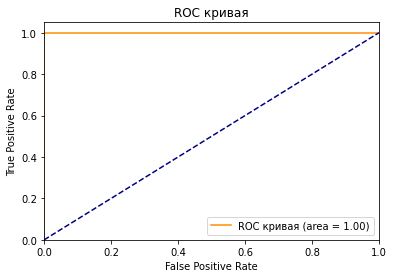

In [205]:
lr_auc = roc_auc_score(y_test.values, predictions)
print('LogisticRegression: ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test.values, predictions)
roc_auc = auc(fpr, tpr)
# строим график
fig = plt.gcf()
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая')
plt.legend(loc="lower right")
plt.show()

In [206]:
fig.savefig('foo.png', dpi=200)